In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sklearn
import statsmodels.api as sm

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")


In [2]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Generic classification and optimization functions from cs019 lab7
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Make ROC Plots

from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #


In [3]:
df=pd.read_csv("data/finaldata/dftouse.csv")
df.head()

,Unnamed: 0,num_schools,num_charter_schools,num_pub_schools,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,fipst,totd912,ebs912,drp912,totdpl,afgeb,afgr,totohc,i_agency_type_local_school_district,i_agency_type_local_school_district_sup_union,i_agency_type_regional_education_services,i_agency_type_charter_school_agency,i_fin_sdlc_sec,i_fin_sdlc_elem_sec,i_fin_sdlc_voc,i_ucl_city_large,i_ucl_city_mid,i_ucl_city_small,i_ucl_suburb_large,i_ucl_suburb_mid,i_ucl_suburb_small,i_ucl_town_fringe,...,r_lrev_pt,r_lrev_gst,r_lrev_put,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation
0,1,1,1,1,15.65,17.14,11111,356,7925,2831,3986,4717,436,4133,1028,11197,1986,72,9139,3986,11.2,43.6,4.8,45.2,51.6,25.5,3.2,71.3,18,0,100,0.0,13,43,30.2,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0,0,0.070312,0.390625,0.000000,0,0.062500,0.000000,0.000000,0.000000,0,0.000000,0.078125,0.007812,0.000000,0.390625,0,0.00000,0.964599,0.000000,0.000000,0.000000,0.003155,0.000000,0,0,0.003155,0.000000,0.029092,0.000000,0.000000,0,0.606477,0.000000,0.156035,0.000000,0.000000,0.000000,0.176644,0.060844,0,0,0,0.000000,0,1
1,2,1,1,1,28.49,28.49,10557,10285,273,0,5104,3003,0,4199,1456,8732,554,0,8108,5104,18.0,63.0,0.0,51.8,37.0,0.0,97.4,2.6,42,33,483,6.8,102,77,100.0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.983958,0.005893,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.010149,0.000000,0.000000,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.950617,0.000000,0.000000,0,0,0.000000,0.000000,0.049383,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,1,0
2,10,1,1,1,16.61,16.61,11015,68,9164,1784,4890,3500,441,5788,477,8864,0,1,8832,4890,5.4,55.4,5.0,65.5,39.6,16.2,0.6,83.2,48,0,228,0.0,39,70,55.7,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0.800000,0.000000,0.000000,0.000000,0,0.142857,0.000000,0.000000,0.057143,0.000000,0,0.00000,0.952145,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000211,0.006233,0.040038,0.001373,0,0.351058,0.056430,0.238741,0.033641,0.000000,0.000000,0.320130,0.000000,0,0,0,0.000000,0,1
3,13,3,0,3,11.86,12.08,11367,4374,5089,1904,4835,4633,498,5741,2112,13200,2204,0,9966,4835,21.2,48.5,5.0,57.6,46.5,16.7,38.5,44.8,17,0,130,0.0,29,41,70.7,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0.798637,0.000000,0.000000,0.000000,0,0,0.000000,0.001049,0.000000,0,0.060829,0.009963,0.014683,0.000000,0,0.005244,0.052438,0.027792,0.004195,0.000000,0,0.02517,0.642181,0.049572,0.068049,0.000000,0.004056,0.000901,0,0,0.000000,0.000901,0.015773,0.218567,0.000000,0,0.162651,0.306024,0.087952,0.038554,0.002410,0.000000,0.402410,0.000000,0,0,0,0.000000,0,1
4,14,2,0,2,15.64,13.37,10718,5634,4020,1065,4944,2103,336,4703,1438,11586,2769,0,7384,4944,19.5,67.0,4.6,63.7,28.5,9.9,52.6,37.5,19,0,168,0.0,45,47,95.7,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0.613364,0.101505,0.055343,0.061464,0,0,0.000000,0.043101,0.000000,0,0.034175,0.008926,0.004336,0.002805,0,0.004081,0.066820,0.000000,0.000000,0.004081,0,0.00000,0.859543,0.000000,0.000000,0.118656,0.000000,0.002144,0,0,0.000000,0.001072,0.018585,0.000000,0.000000,0,0.095816,0.10

In [4]:
# Create test/train mask
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

# make sure we didn't get unlucky in our mask selection
print "% High_Graduation in Training:", np.mean(df['RESP_High_Graduation'][mask])
print "% High_Graduation in Testing:", np.mean(df['RESP_High_Graduation'][~mask])


% High_Graduation in Training: 0.250629222414
% High_Graduation in Testing: 0.245364647713


** Indicators used : Funding/Expenditure/Location/School and Race/Sex **

In [5]:
Xnames = [
    'num_schools',
    'num_charter_schools',
    'num_pub_schools',
    'pupil_teacher_ratio_dist',
    'totalrev_pp',
    'tcurinst_pp',
    'tcurssv_pp',
    'tcuroth_pp',
    'tcursalary_pp',
    'tcurbenefits_pp',
    'totalexp_pp',
    'r_stud_re_AAP',
    'r_stud_re_H',
    'r_stud_re_B',
    'r_stud_re_W'
]

# Indicators used : Funding/Expenditure/Location/School Types and Race/Sex
Xnames1 = [
    'pupil_teacher_ratio_dist',
            'totalrev_pp',
            'tcurinst_pp',
            'tcurssv_pp',
            'tcursalary_pp',
            'tcurbenefits_pp',
            'totalexp_pp',
            'tcapout_pp',
            'tnonelse_pp',
            'tcurelsc_pp',
            'instexp_pp',
            'i_agency_type_local_school_district',
            'i_agency_type_local_school_district_sup_union',
            'i_agency_type_regional_education_services',
            'i_agency_type_charter_school_agency',
            'i_fin_sdlc_sec',
            'i_fin_sdlc_elem_sec',
            'i_fin_sdlc_voc',
            'i_ucl_city_large',
            'i_ucl_city_mid',
            'i_ucl_city_small',
            'i_ucl_suburb_large',
            'i_ucl_suburb_mid',
            'i_ucl_suburb_small',
            'i_ucl_town_fringe',
            'i_ucl_town_distant',
            'i_ucl_town_remote',
            'i_ucl_rural_fringe',
            'i_ucl_rural_distant',
            'i_ucl_rural_remote',
            'i_cs_all_charter',
            'i_cs_charter_noncharter',
            'i_cs_all_noncharter',
            'i_ma_ne_nr',
            'i_ma_metropolitan',
            'i_ma_micropolitan',            
            'r_ELL',
            'r_IEP',
            'r_stud_re_M',
            'r_stud_re_F',
            'r_stud_re_AIAN',
            'r_stud_re_AAP',
            'r_stud_re_H',
            'r_stud_re_B',
            'r_stud_re_W',
            'r_stud_re_HNPI',
            'r_stud_re_Two'   
]


# RESP_High_Graduation
# RESP_Low_Graduation
target = 'RESP_High_Graduation'
target1 = 'RESP_High_Graduation'


using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'max_depth': 7, 'min_samples_leaf': 1} 0.297695464646 [mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 7}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 8}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 9}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 10}, mean: 0.01664, std: 0.00600, params: {'max_depth': 2, 'min_samples_leaf': 1}, mean: 0.01664, std: 0.00600, params: {'max_depth': 2, 'min_samples_leaf': 2}, me

/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


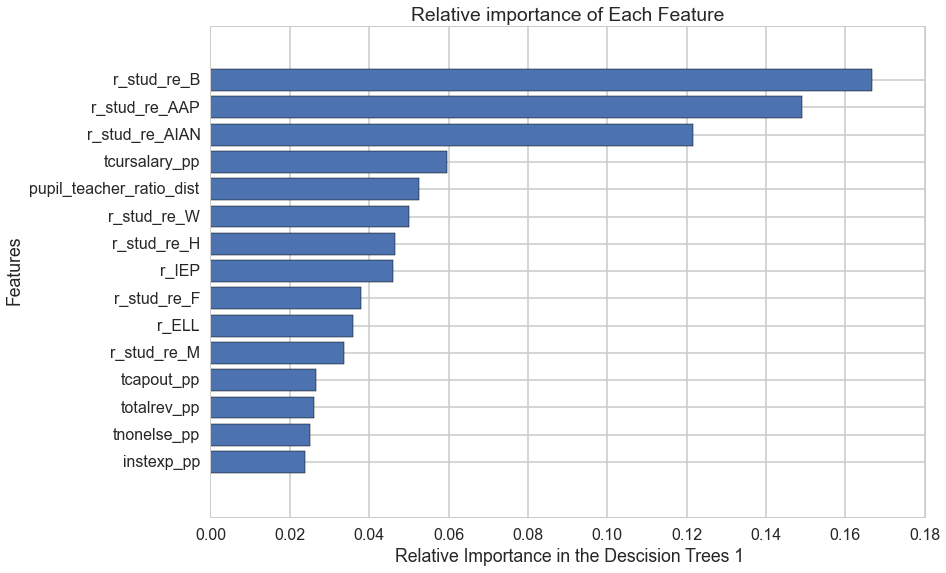

In [6]:
# Descision Trees
from sklearn import tree

clfTree1 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1, parameters, df, 
                                                     Xnames1, target1, 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

importance_list = clfTree1.feature_importances_
name_list = df[Xnames1].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Descision Trees 1')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 3} 0.389083201511 [mean: 0.34732, std: 0.01130, params: {'n_estimators': 1}, mean: 0.23671, std: 0.01967, params: {'n_estimators': 2}, mean: 0.38908, std: 0.01788, params: {'n_estimators': 3}, mean: 0.27157, std: 0.01221, params: {'n_estimators': 4}, mean: 0.36034, std: 0.01566, params: {'n_estimators': 5}, mean: 0.27255, std: 0.03870, params: {'n_estimators': 6}, mean: 0.34929, std: 0.01165, params: {'n_estimators': 7}, mean: 0.29058, std: 0.02190, params: {'n_estimators': 8}, mean: 0.35278, std: 0.03871, params: {'n_estimators': 9}]
############# based on standard predict ################
Accuracy on training data: 0.95
Accuracy on test data:     0.71
[[2046  396]
 [ 548  246]]
########################################################


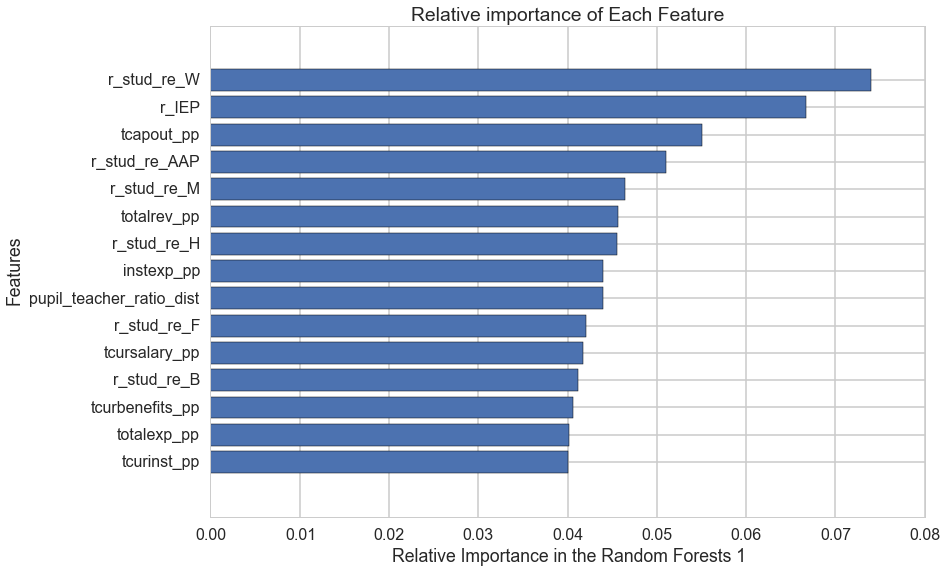

In [10]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier

clfForest1 = RandomForestClassifier()

parameters = {"n_estimators": range(1, 10)}
clfForest1, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest1, parameters, 
                                                       df, Xnames1, target1, 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

importance_list = clfForest1.feature_importances_
name_list = df[Xnames1].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forests 1')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 43} 0.324411146205 [mean: 0.24978, std: 0.03163, params: {'n_estimators': 10}, mean: 0.25854, std: 0.03633, params: {'n_estimators': 11}, mean: 0.26704, std: 0.02652, params: {'n_estimators': 12}, mean: 0.27308, std: 0.03180, params: {'n_estimators': 13}, mean: 0.26542, std: 0.02709, params: {'n_estimators': 14}, mean: 0.27562, std: 0.03637, params: {'n_estimators': 15}, mean: 0.27901, std: 0.03717, params: {'n_estimators': 16}, mean: 0.28580, std: 0.03201, params: {'n_estimators': 17}, mean: 0.28119, std: 0.02700, params: {'n_estimators': 18}, mean: 0.28611, std: 0.02959, params: {'n_estimators': 19}, mean: 0.29327, std: 0.03124, params: {'n_estimators': 20}, mean: 0.29404, std: 0.03591, params: {'n_estimators': 21}, mean: 0.29020, std: 0.02945, params: {'n_estimators': 22}, mean: 0.29838, std: 0.03660, params: {'n_estimators': 23}, mean: 0.30228, std: 0.03371, params: {'n_estimators': 24}, mean: 0.29913, std: 0.03278, params: {'n_estimators': 25}, mean: 0.30575,

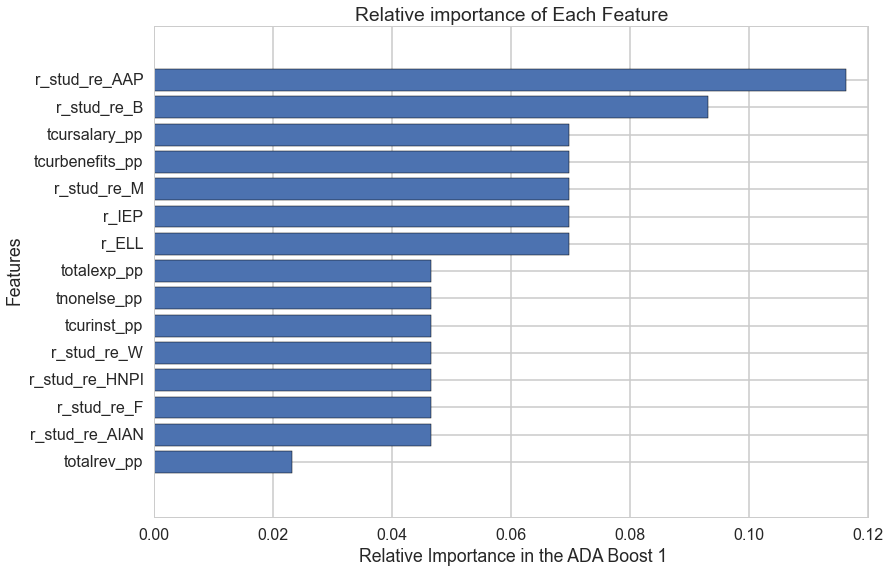

In [11]:
# ADA Booster
from sklearn.ensemble import AdaBoostClassifier

clfAda1 = AdaBoostClassifier()

parameters = {"n_estimators": range(10, 60)}
clfAda1, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda1, parameters, 
                                                       df, Xnames1, target1, 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

importance_list = clfAda1.feature_importances_
name_list = df[Xnames1].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the ADA Boost 1')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 57, 'max_depth': 5} 0.306368205558 [mean: 0.00000, std: 0.00000, params: {'n_estimators': 30, 'max_depth': 1}, mean: 0.00000, std: 0.00000, params: {'n_estimators': 31, 'max_depth': 1}, mean: 0.00000, std: 0.00000, params: {'n_estimators': 32, 'max_depth': 1}, mean: 0.00627, std: 0.00767, params: {'n_estimators': 33, 'max_depth': 1}, mean: 0.00627, std: 0.00767, params: {'n_estimators': 34, 'max_depth': 1}, mean: 0.00732, std: 0.00708, params: {'n_estimators': 35, 'max_depth': 1}, mean: 0.01046, std: 0.00736, params: {'n_estimators': 36, 'max_depth': 1}, mean: 0.01149, std: 0.00832, params: {'n_estimators': 37, 'max_depth': 1}, mean: 0.01149, std: 0.00832, params: {'n_estimators': 38, 'max_depth': 1}, mean: 0.01149, std: 0.00832, params: {'n_estimators': 39, 'max_depth': 1}, mean: 0.01356, std: 0.00905, params: {'n_estimators': 40, 'max_depth': 1}, mean: 0.01461, std: 0.00832, params: {'n_estimators': 41, 'max_depth': 1}, mean: 0.01770, std: 0.00956, params: {'n_e

/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


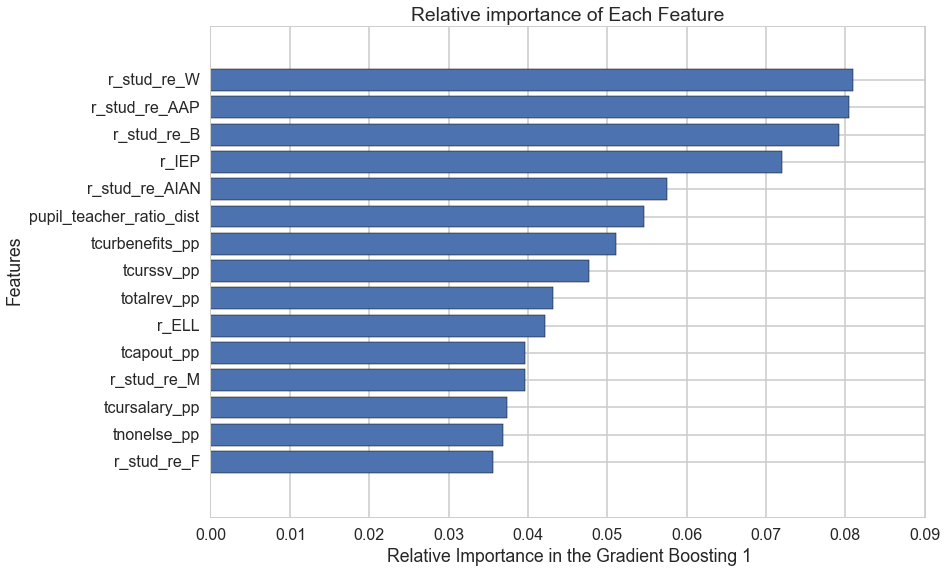

In [12]:
# Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

clfGB1 = GradientBoostingClassifier()

parameters = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB1, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB1, parameters, 
                                                       df, Xnames1, target1, 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

importance_list = clfGB1.feature_importances_
name_list = df[Xnames1].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Gradient Boosting 1')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

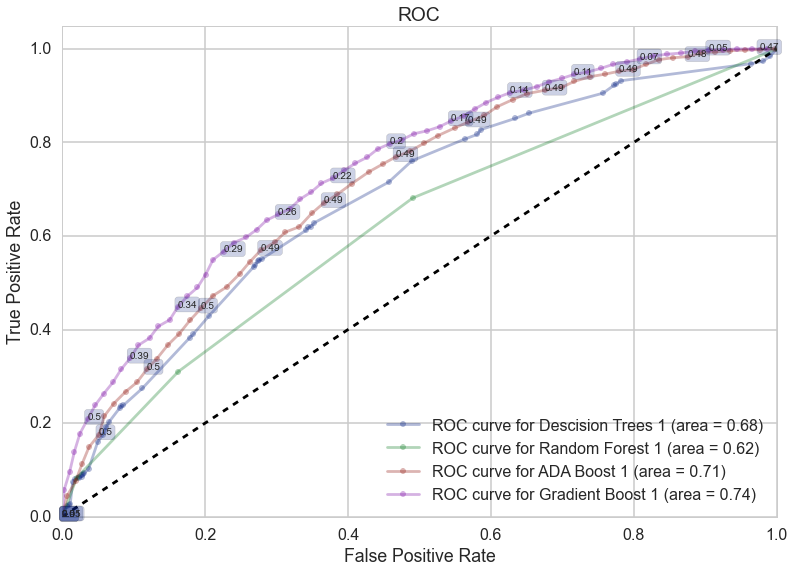

In [49]:
# Plotting ROC Curves

with sns.color_palette("dark"):
    ax=make_roc("Descision Trees 1",clfTree1  , ytest, Xtest, None, labe=250, proba=True)
    make_roc("Random Forest 1"     ,clfForest1, ytest, Xtest, ax  , labe=250, proba=True);
    make_roc("ADA Boost 1"         ,clfAda1   , ytest, Xtest, ax  , labe=250, proba=True, skip=50);
    make_roc("Gradient Boost 1"    ,clfGB1    , ytest, Xtest, ax  , labe=250, proba=True, skip=50);
 


** Indicators used : Funding/Expenditure/Location/School Types. No Race or Sex **

In [50]:
# Indicators used : Funding/Expenditure/Location/School Types (no Race)

Xnames2 = [
            'pupil_teacher_ratio_dist',
            'totalrev_pp',
            'tcurinst_pp',
            'tcurssv_pp',
            'tcursalary_pp',
            'tcurbenefits_pp',
            'totalexp_pp',
            'tcapout_pp',
            'tnonelse_pp',
            'tcurelsc_pp',
            'instexp_pp',
            'i_agency_type_local_school_district',
            'i_agency_type_local_school_district_sup_union',
            'i_agency_type_regional_education_services',
            'i_agency_type_charter_school_agency',
            'i_fin_sdlc_sec',
            'i_fin_sdlc_elem_sec',
            'i_fin_sdlc_voc',
            'i_ucl_city_large',
            'i_ucl_city_mid',
            'i_ucl_city_small',
            'i_ucl_suburb_large',
            'i_ucl_suburb_mid',
            'i_ucl_suburb_small',
            'i_ucl_town_fringe',
            'i_ucl_town_distant',
            'i_ucl_town_remote',
            'i_ucl_rural_fringe',
            'i_ucl_rural_distant',
            'i_ucl_rural_remote',
            'i_cs_all_charter',
            'i_cs_charter_noncharter',
            'i_cs_all_noncharter',
            'i_ma_ne_nr',
            'i_ma_metropolitan',
            'i_ma_micropolitan',            
            'r_ELL',
            'r_IEP'
]

# RESP_High_Graduation
# RESP_Low_Graduation

target2 = 'RESP_High_Graduation'


using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'max_depth': 7, 'min_samples_leaf': 10} 0.263772756866 [mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 7}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 8}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 9}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 10}, mean: 0.00000, std: 0.00000, params: {'max_depth': 2, 'min_samples_leaf': 1}, mean: 0.00000, std: 0.00000, params: {'max_depth': 2, 'min_samples_leaf': 2}, m

/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


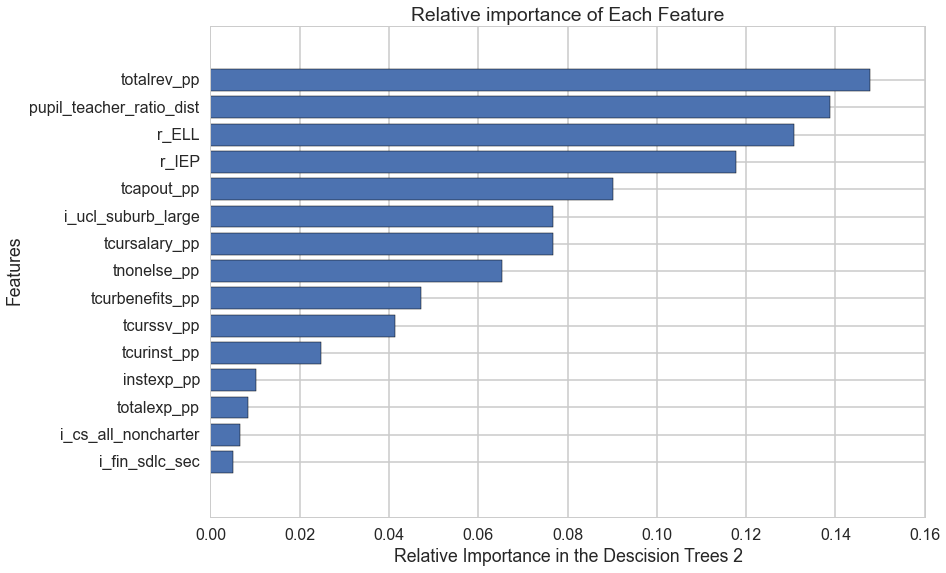

In [51]:
# Descision Tree
clfTree2 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
clfTree2, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree2, parameters, df, 
                                                     Xnames2, target2, 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

importance_list = clfTree2.feature_importances_
name_list = df[Xnames2].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Descision Trees 2')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()


using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 1} 0.340060993014 [mean: 0.34006, std: 0.01008, params: {'n_estimators': 1}, mean: 0.20658, std: 0.02653, params: {'n_estimators': 2}, mean: 0.31833, std: 0.02403, params: {'n_estimators': 3}, mean: 0.23419, std: 0.02534, params: {'n_estimators': 4}, mean: 0.30296, std: 0.01903, params: {'n_estimators': 5}, mean: 0.23298, std: 0.01663, params: {'n_estimators': 6}, mean: 0.29432, std: 0.01500, params: {'n_estimators': 7}, mean: 0.22799, std: 0.02712, params: {'n_estimators': 8}, mean: 0.28350, std: 0.02068, params: {'n_estimators': 9}]
############# based on standard predict ################
Accuracy on training data: 0.87
Accuracy on test data:     0.66
[[1884  558]
 [ 536  258]]
########################################################


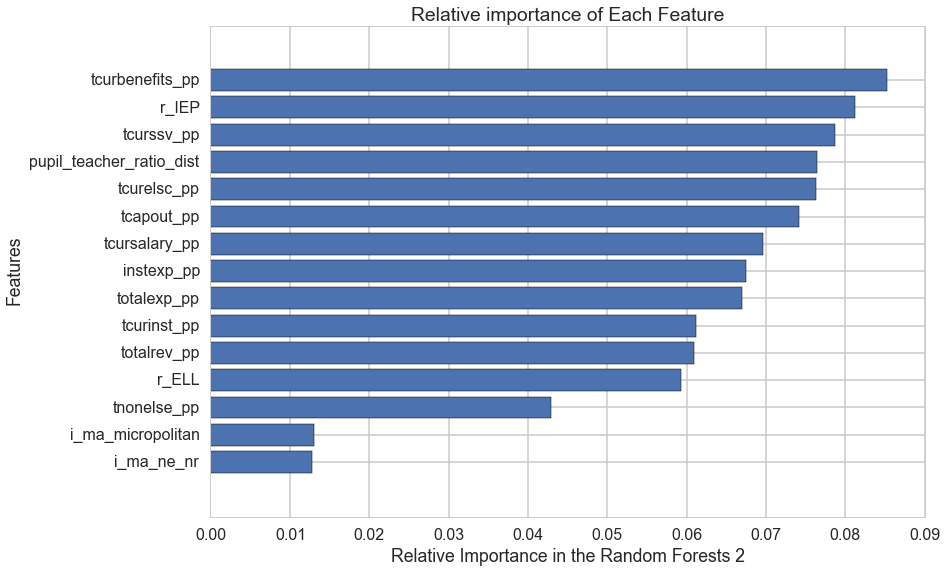

In [53]:
# Random Forests
clfForest2 = RandomForestClassifier()

parameters = {"n_estimators": range(1, 10)}
clfForest2, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest2, parameters, 
                                                       df, Xnames2, target2, 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

importance_list = clfForest2.feature_importances_
name_list = df[Xnames2].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forests 2')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 51} 0.162921484189 [mean: 0.08421, std: 0.02379, params: {'n_estimators': 10}, mean: 0.07581, std: 0.00553, params: {'n_estimators': 11}, mean: 0.08928, std: 0.00954, params: {'n_estimators': 12}, mean: 0.09457, std: 0.00995, params: {'n_estimators': 13}, mean: 0.09176, std: 0.00744, params: {'n_estimators': 14}, mean: 0.09884, std: 0.01634, params: {'n_estimators': 15}, mean: 0.10381, std: 0.01151, params: {'n_estimators': 16}, mean: 0.12037, std: 0.01128, params: {'n_estimators': 17}, mean: 0.11814, std: 0.01086, params: {'n_estimators': 18}, mean: 0.12186, std: 0.01571, params: {'n_estimators': 19}, mean: 0.11333, std: 0.01652, params: {'n_estimators': 20}, mean: 0.11660, std: 0.01733, params: {'n_estimators': 21}, mean: 0.11582, std: 0.01021, params: {'n_estimators': 22}, mean: 0.12123, std: 0.01922, params: {'n_estimators': 23}, mean: 0.11695, std: 0.01662, params: {'n_estimators': 24}, mean: 0.13294, std: 0.02531, params: {'n_estimators': 25}, mean: 0.12316,

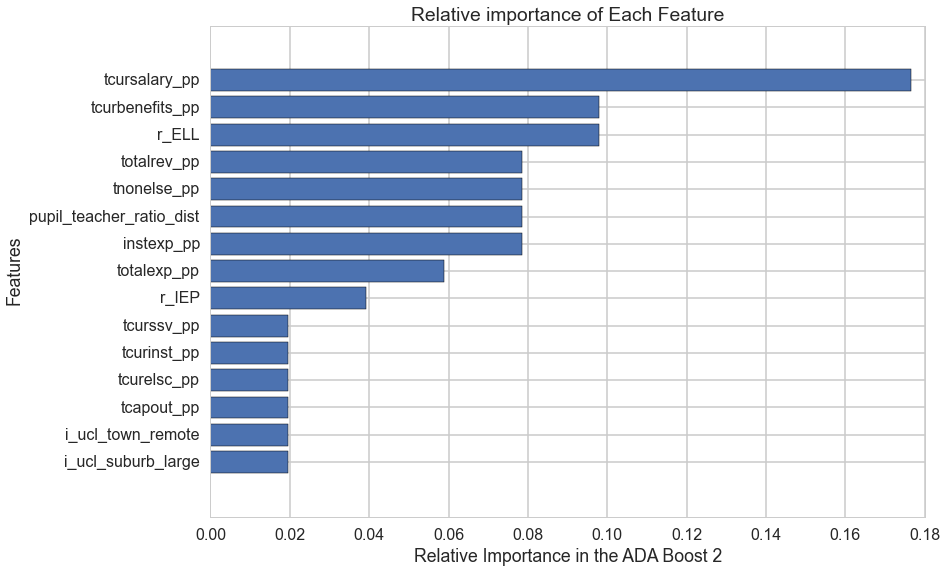

In [54]:
# ADA Booster
clfAda2 = AdaBoostClassifier()

parameters = {"n_estimators": range(10, 60)}
clfAda2, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda2, parameters, 
                                                       df, Xnames2, target2, 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

importance_list = clfAda2.feature_importances_
name_list = df[Xnames2].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the ADA Boost 2')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 59, 'max_depth': 5} 0.227010998247 [mean: 0.00000, std: 0.00000, params: {'n_estimators': 30, 'max_depth': 1}, mean: 0.00000, std: 0.00000, params: {'n_estimators': 31, 'max_depth': 1}, mean: 0.00000, std: 0.00000, params: {'n_estimators': 32, 'max_depth': 1}, mean: 0.00105, std: 0.00211, params: {'n_estimators': 33, 'max_depth': 1}, mean: 0.00105, std: 0.00211, params: {'n_estimators': 34, 'max_depth': 1}, mean: 0.00105, std: 0.00211, params: {'n_estimators': 35, 'max_depth': 1}, mean: 0.00105, std: 0.00211, params: {'n_estimators': 36, 'max_depth': 1}, mean: 0.00211, std: 0.00258, params: {'n_estimators': 37, 'max_depth': 1}, mean: 0.00211, std: 0.00258, params: {'n_estimators': 38, 'max_depth': 1}, mean: 0.00211, std: 0.00258, params: {'n_estimators': 39, 'max_depth': 1}, mean: 0.00211, std: 0.00258, params: {'n_estimators': 40, 'max_depth': 1}, mean: 0.00211, std: 0.00258, params: {'n_estimators': 41, 'max_depth': 1}, mean: 0.00315, std: 0.00419, params: {'n_e

/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


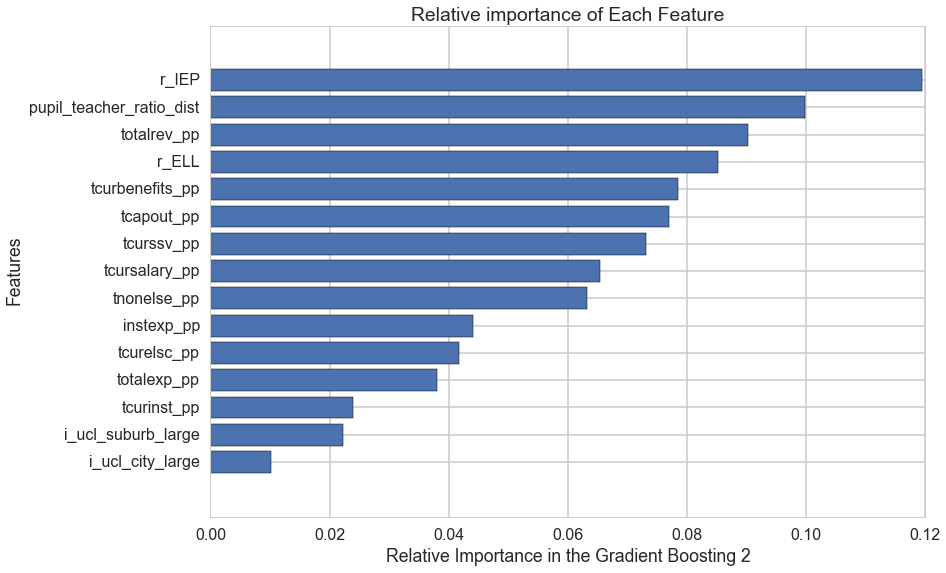

In [55]:
# Gradient Boosting
clfGB2 = GradientBoostingClassifier()

parameters = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB2, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB2, parameters, 
                                                       df, Xnames2, target2, 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

importance_list = clfGB2.feature_importances_
name_list = df[Xnames2].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Gradient Boosting 2')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

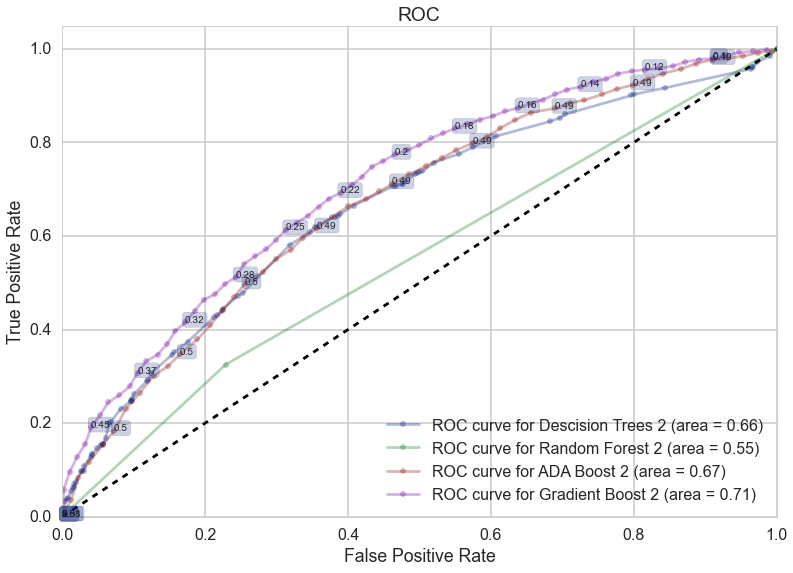

In [56]:
with sns.color_palette("dark"):
    ax=make_roc("Descision Trees 2",clfTree2  , ytest, Xtest, None, labe=250, proba=True)
    make_roc("Random Forest 2"     ,clfForest2, ytest, Xtest, ax  , labe=250, proba=True);
    make_roc("ADA Boost 2"         ,clfAda2   , ytest, Xtest, ax  , labe=250, proba=True, skip=50);
    make_roc("Gradient Boost 2"    ,clfGB2    , ytest, Xtest, ax  , labe=250, proba=True, skip=50);
 